## Parameters

In [52]:
import torch.nn as nn

record_number = 223
network_structure = [4, 8, 8, 5]
n_epochs = 45
batch_size = 100
act1 = nn.Tanh()
act2 = nn.Sigmoid()

sampling_strategy = {1: 90083, 2: 10000, 3: 3500, 4: 1500, 5: 80}
# filename = f'{act1}-{act2}-{network_structure}--{batch_size}{record_number}.png'
full_path = "full_data_set.png"

## Importing Data

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("kaggle.csv")

In [54]:
df = df[["record", "type", "0_qrs_interval", "0_pre-RR", "0_post-RR", "0_qt_interval", "0_st_interval"]]
df.dropna(inplace=True)

## Making outputs

In [55]:
df["type"] = df["type"].map({"N": 1, "VEB": 2, "SVEB": 3, "F": 4, "Q":5})

## Making x, y

In [56]:
X = df[["0_pre-RR", "0_qrs_interval", "0_qt_interval", "0_st_interval"]]
y = df["type"]

In [57]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0, sampling_strategy=sampling_strategy)
X, y = sm.fit_resample(X=X, y=y)

In [58]:
X = (X - X.mean()) / X.std()
y = y.map(
    {1: [1, 0, 0, 0, 0], 2: [0, 1, 0, 0, 0], 3: [0, 0, 1, 0, 0], 4: [0, 0, 0, 1, 0] , 5: [0, 0, 0, 0, 1]}
)
y = np.array(y.tolist())

In [59]:
y = np.array(y.tolist())

## Splitting data for training and testing

In [60]:
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(X.values).float()
y = torch.from_numpy(y).float()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

## Arrhythmia Classifier

In [61]:
class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(network_structure[0], network_structure[1])
        self.act1 = act1
        self.hidden2 = nn.Linear(network_structure[1],network_structure[2])
        self.act2 = act2
        self.output = nn.Linear(network_structure[2], network_structure[3])

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=8, out_features=8, bias=True)
  (act2): Sigmoid()
  (output): Linear(in_features=8, out_features=5, bias=True)
)

In [62]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
random.seed(10)

In [63]:
import tqdm
import copy


batches_per_epoch = len(X_train) // batch_size

best_acc = -np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 736/736 [00:02<00:00, 261.91batch/s, acc=0.91, loss=0.315]


Epoch 0 validation: Cross-entropy=0.3190964460372925, Accuracy=0.9128022789955139


Epoch 1: 100%|██████████| 736/736 [00:03<00:00, 239.62batch/s, acc=0.91, loss=0.281] 


Epoch 1 validation: Cross-entropy=0.30242565274238586, Accuracy=0.9136897921562195


Epoch 2: 100%|██████████| 736/736 [00:03<00:00, 234.54batch/s, acc=0.91, loss=0.269] 


Epoch 2 validation: Cross-entropy=0.2884907126426697, Accuracy=0.9146090149879456


Epoch 3: 100%|██████████| 736/736 [00:02<00:00, 250.98batch/s, acc=0.91, loss=0.256] 


Epoch 3 validation: Cross-entropy=0.2760032117366791, Accuracy=0.9148942828178406


Epoch 4: 100%|██████████| 736/736 [00:02<00:00, 256.33batch/s, acc=0.91, loss=0.247] 


Epoch 4 validation: Cross-entropy=0.2688741087913513, Accuracy=0.9162889719009399


Epoch 5: 100%|██████████| 736/736 [00:02<00:00, 268.04batch/s, acc=0.9, loss=0.237]  


Epoch 5 validation: Cross-entropy=0.2644781768321991, Accuracy=0.9160987734794617


Epoch 6: 100%|██████████| 736/736 [00:02<00:00, 262.70batch/s, acc=0.9, loss=0.229]  


Epoch 6 validation: Cross-entropy=0.26165369153022766, Accuracy=0.9158135056495667


Epoch 7: 100%|██████████| 736/736 [00:02<00:00, 272.14batch/s, acc=0.9, loss=0.225] 


Epoch 7 validation: Cross-entropy=0.25964486598968506, Accuracy=0.9164157509803772


Epoch 8: 100%|██████████| 736/736 [00:02<00:00, 259.46batch/s, acc=0.91, loss=0.224] 


Epoch 8 validation: Cross-entropy=0.2581908106803894, Accuracy=0.9175885319709778


Epoch 9: 100%|██████████| 736/736 [00:02<00:00, 291.06batch/s, acc=0.91, loss=0.225] 


Epoch 9 validation: Cross-entropy=0.25716307759284973, Accuracy=0.9179688692092896


Epoch 10: 100%|██████████| 736/736 [00:02<00:00, 284.81batch/s, acc=0.91, loss=0.227] 


Epoch 10 validation: Cross-entropy=0.25640562176704407, Accuracy=0.9183809161186218


Epoch 11: 100%|██████████| 736/736 [00:02<00:00, 287.15batch/s, acc=0.91, loss=0.228] 


Epoch 11 validation: Cross-entropy=0.2558386027812958, Accuracy=0.9181590676307678


Epoch 12: 100%|██████████| 736/736 [00:02<00:00, 263.84batch/s, acc=0.91, loss=0.23]  


Epoch 12 validation: Cross-entropy=0.25540775060653687, Accuracy=0.9180005788803101


Epoch 13: 100%|██████████| 736/736 [00:02<00:00, 267.68batch/s, acc=0.91, loss=0.231] 


Epoch 13 validation: Cross-entropy=0.25507429242134094, Accuracy=0.9179055094718933


Epoch 14: 100%|██████████| 736/736 [00:02<00:00, 267.19batch/s, acc=0.91, loss=0.231] 


Epoch 14 validation: Cross-entropy=0.2548113465309143, Accuracy=0.9180322885513306


Epoch 15: 100%|██████████| 736/736 [00:02<00:00, 272.37batch/s, acc=0.91, loss=0.232] 


Epoch 15 validation: Cross-entropy=0.25459834933280945, Accuracy=0.9182541370391846


Epoch 16: 100%|██████████| 736/736 [00:02<00:00, 257.27batch/s, acc=0.91, loss=0.232] 


Epoch 16 validation: Cross-entropy=0.2544192969799042, Accuracy=0.9180956482887268


Epoch 17: 100%|██████████| 736/736 [00:02<00:00, 273.52batch/s, acc=0.91, loss=0.232] 


Epoch 17 validation: Cross-entropy=0.2542620003223419, Accuracy=0.9183175563812256


Epoch 18: 100%|██████████| 736/736 [00:02<00:00, 272.07batch/s, acc=0.91, loss=0.232] 


Epoch 18 validation: Cross-entropy=0.25411805510520935, Accuracy=0.9182224273681641


Epoch 19: 100%|██████████| 736/736 [00:02<00:00, 270.71batch/s, acc=0.91, loss=0.231] 


Epoch 19 validation: Cross-entropy=0.25398334860801697, Accuracy=0.9184443354606628


Epoch 20: 100%|██████████| 736/736 [00:02<00:00, 248.04batch/s, acc=0.91, loss=0.231] 


Epoch 20 validation: Cross-entropy=0.25385773181915283, Accuracy=0.9182224273681641


Epoch 21: 100%|██████████| 736/736 [00:02<00:00, 252.91batch/s, acc=0.91, loss=0.23]  


Epoch 21 validation: Cross-entropy=0.2537425458431244, Accuracy=0.917937159538269


Epoch 22: 100%|██████████| 736/736 [00:02<00:00, 298.44batch/s, acc=0.91, loss=0.23]  


Epoch 22 validation: Cross-entropy=0.2536366283893585, Accuracy=0.9178420901298523


Epoch 23: 100%|██████████| 736/736 [00:02<00:00, 261.56batch/s, acc=0.91, loss=0.229] 


Epoch 23 validation: Cross-entropy=0.25353777408599854, Accuracy=0.9176836013793945


Epoch 24: 100%|██████████| 736/736 [00:02<00:00, 268.93batch/s, acc=0.91, loss=0.228] 


Epoch 24 validation: Cross-entropy=0.2534446716308594, Accuracy=0.9173983335494995


Epoch 25: 100%|██████████| 736/736 [00:02<00:00, 301.19batch/s, acc=0.91, loss=0.227] 


Epoch 25 validation: Cross-entropy=0.25335538387298584, Accuracy=0.9173349142074585


Epoch 26: 100%|██████████| 736/736 [00:02<00:00, 315.96batch/s, acc=0.91, loss=0.227] 


Epoch 26 validation: Cross-entropy=0.25326696038246155, Accuracy=0.9172081351280212


Epoch 27: 100%|██████████| 736/736 [00:02<00:00, 315.83batch/s, acc=0.91, loss=0.226] 


Epoch 27 validation: Cross-entropy=0.25317680835723877, Accuracy=0.9169545769691467


Epoch 28: 100%|██████████| 736/736 [00:02<00:00, 294.44batch/s, acc=0.91, loss=0.226] 


Epoch 28 validation: Cross-entropy=0.2530842125415802, Accuracy=0.9171130657196045


Epoch 29: 100%|██████████| 736/736 [00:02<00:00, 280.85batch/s, acc=0.91, loss=0.225] 


Epoch 29 validation: Cross-entropy=0.2529899775981903, Accuracy=0.917081356048584


Epoch 30: 100%|██████████| 736/736 [00:02<00:00, 291.21batch/s, acc=0.91, loss=0.225] 


Epoch 30 validation: Cross-entropy=0.25289520621299744, Accuracy=0.917081356048584


Epoch 31: 100%|██████████| 736/736 [00:02<00:00, 287.48batch/s, acc=0.9, loss=0.224]  


Epoch 31 validation: Cross-entropy=0.25280046463012695, Accuracy=0.9171764850616455


Epoch 32: 100%|██████████| 736/736 [00:02<00:00, 285.19batch/s, acc=0.9, loss=0.224]  


Epoch 32 validation: Cross-entropy=0.25270572304725647, Accuracy=0.9172715544700623


Epoch 33: 100%|██████████| 736/736 [00:02<00:00, 276.96batch/s, acc=0.9, loss=0.224]  


Epoch 33 validation: Cross-entropy=0.25261062383651733, Accuracy=0.9172398447990417


Epoch 34: 100%|██████████| 736/736 [00:02<00:00, 290.37batch/s, acc=0.91, loss=0.224] 


Epoch 34 validation: Cross-entropy=0.2525143623352051, Accuracy=0.9173032641410828


Epoch 35: 100%|██████████| 736/736 [00:02<00:00, 276.18batch/s, acc=0.91, loss=0.223] 


Epoch 35 validation: Cross-entropy=0.2524159848690033, Accuracy=0.9173983335494995


Epoch 36: 100%|██████████| 736/736 [00:02<00:00, 308.71batch/s, acc=0.91, loss=0.223] 


Epoch 36 validation: Cross-entropy=0.2523142993450165, Accuracy=0.9176201820373535


Epoch 37: 100%|██████████| 736/736 [00:02<00:00, 314.63batch/s, acc=0.91, loss=0.223] 


Epoch 37 validation: Cross-entropy=0.2522077262401581, Accuracy=0.9177786707878113


Epoch 38: 100%|██████████| 736/736 [00:02<00:00, 314.18batch/s, acc=0.91, loss=0.223] 


Epoch 38 validation: Cross-entropy=0.25209468603134155, Accuracy=0.9179055094718933


Epoch 39: 100%|██████████| 736/736 [00:02<00:00, 311.28batch/s, acc=0.91, loss=0.222] 


Epoch 39 validation: Cross-entropy=0.2519744038581848, Accuracy=0.9178737998008728


Epoch 40: 100%|██████████| 736/736 [00:02<00:00, 318.94batch/s, acc=0.91, loss=0.222] 


Epoch 40 validation: Cross-entropy=0.25184905529022217, Accuracy=0.9178737998008728


Epoch 41: 100%|██████████| 736/736 [00:02<00:00, 311.60batch/s, acc=0.91, loss=0.222] 


Epoch 41 validation: Cross-entropy=0.2517243027687073, Accuracy=0.9178737998008728


Epoch 42: 100%|██████████| 736/736 [00:02<00:00, 325.29batch/s, acc=0.91, loss=0.221] 


Epoch 42 validation: Cross-entropy=0.2516063451766968, Accuracy=0.9179055094718933


Epoch 43: 100%|██████████| 736/736 [00:02<00:00, 313.91batch/s, acc=0.91, loss=0.221] 


Epoch 43 validation: Cross-entropy=0.2514979839324951, Accuracy=0.9180956482887268


Epoch 44: 100%|██████████| 736/736 [00:02<00:00, 343.35batch/s, acc=0.91, loss=0.221] 


Epoch 44 validation: Cross-entropy=0.2513985335826874, Accuracy=0.917937159538269


<All keys matched successfully>

In [64]:
model.state_dict()

OrderedDict([('hidden1.weight',
              tensor([[-3.9888e-01,  1.9422e+00, -1.4536e+00,  1.8833e+00],
                      [-5.1055e-01,  2.3326e+00, -2.1088e+00,  5.7644e+00],
                      [ 1.2513e+00,  1.2435e-01, -2.6063e+00, -2.9950e+00],
                      [ 2.4802e+00, -9.0792e-01,  7.9716e-01, -9.1109e-01],
                      [ 1.1986e-03,  9.1288e-01, -1.1135e-01, -5.0038e-01],
                      [ 3.0012e+00, -1.1357e+00,  2.4785e+00, -1.5200e-01],
                      [-3.9140e+00, -1.2170e+00,  4.0562e-01,  8.2328e-01],
                      [-7.1169e-01, -1.5427e+00,  2.1489e+00,  3.5949e+00]])),
             ('hidden1.bias',
              tensor([ 0.0196,  1.0285, -3.4547,  2.8338, -1.5643,  0.3940, -1.6041, -0.1128])),
             ('hidden2.weight',
              tensor([[ 1.9835e+00, -1.6620e+00,  3.9944e-02,  2.9595e+00,  3.3600e+00,
                        6.0398e+00, -8.3835e-01, -2.4459e+00],
                      [ 9.3697e-05,  8.6017e-01

## Plotting Cross entropy and accuracy

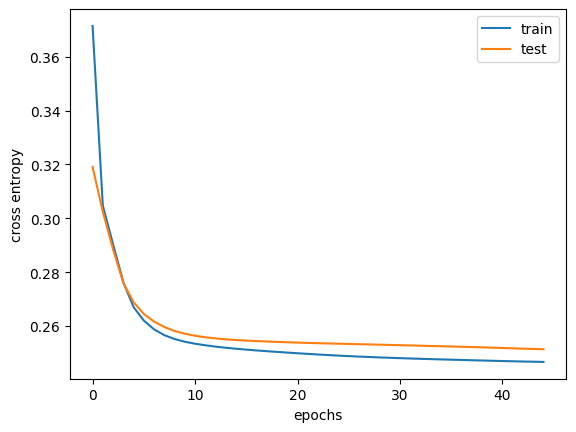

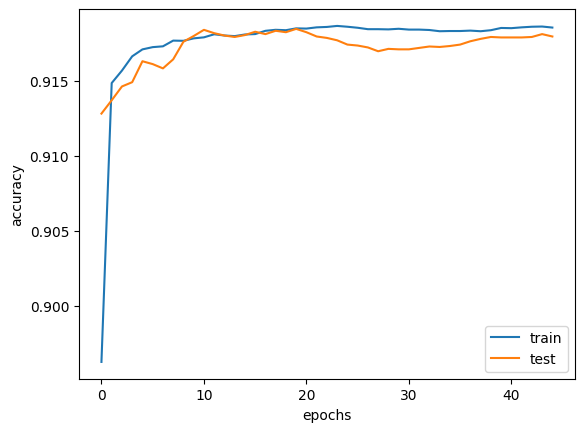

In [66]:
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.savefig("full_data_set_loss.png")
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(full_path)
plt.show()